<a href="https://colab.research.google.com/github/UC44/simple-js-app/blob/main/Telco_Data_Analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency, f_oneway
import numpy as np

# Step 1: Load the Telco_data.csv file into a DataFrame
def load_data(data_path):
    try:
        df = pd.read_csv(data_path)
        print("CSV file loaded successfully!")
        print("First few rows of the data:")
        print(df.head())
        print("\nData info:")
        print(df.info())
        return df
    except FileNotFoundError:
        print(f"Error: The file '{data_path}' was not found. Please check the path.")
        exit(1)

**Step 1: Load the Data**

**What Happens**

* The dataset (Telco_data.csv) is loaded into a Pandas DataFrame.

* Basic information about the dataset is printed, including the first few rows and the data types of each column.

**Analysis**

* This step ensures the dataset is correctly loaded and provides an initial understanding of its structure.

* The info() method reveals the number of rows, columns, and missing values, which is crucial for data cleaning.

In [ ]:
# Step 2: Data Cleaning
def clean_data(df):
    # Convert TotalCharges to numeric and handle errors
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # Impute missing values in TotalCharges with the median
    df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

    # Ensure TotalCharges is numeric and reset index
    df['TotalCharges'] = df['TotalCharges'].astype(float)
    df.reset_index(drop=True, inplace=True)

    print("\nData after cleaning:")
    print(df.info())
    return df

**Step 2: Data Cleaning**

**What Happens**

* The TotalCharges column is converted to numeric, and errors (e.g., empty strings) are handled by coercing them to NaN.

* Missing values in TotalCharges are imputed with the median value.

* The column is explicitly converted to float type, and the DataFrame index is reset.

**Analysis**

* This step ensures data consistency and handles missing values, which is critical for accurate analysis and modeling.

* Imputing missing values with the median minimizes the impact of outliers.

In [ ]:
# Step 3: Univariate Analysis
def univariate_analysis(df, numerical_columns, categorical_columns):
    sns.set(style="whitegrid")

    # Univariate analysis for numerical variables
    for column in numerical_columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(df[column], kde=True, bins=30, color='blue')
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

    # Univariate analysis for categorical variables
    for column in categorical_columns:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)
        plt.title(f'Count of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.show()

**Step 3: Univariate Analysis**

**What Happens**

* Numerical Variables: Histograms with Kernel Density Estimation (KDE) are plotted for tenure, MonthlyCharges, and TotalCharges.

* Categorical Variables: Count plots are created for each categorical variable (e.g., gender, Contract, PaymentMethod).

**Graph Findings**

**Numerical Variables**

* Tenure: The distribution shows how long customers stay with the company. A peak at lower tenure values may indicate high churn in the early months.

* MonthlyCharges: The distribution reveals the range of monthly charges. Bimodal distributions may indicate different customer segments.

* TotalCharges: The distribution shows the total amount paid by customers. A right-skewed distribution suggests most customers have lower total charges.

**Categorical Variables**

* Gender: The count plot shows the balance between male and female customers.

* Contract Type: Reveals the distribution of contract types (e.g., month-to-month, yearly).

* Payment Method: Shows the most common payment methods used by customers.

**Analysis**

* Univariate analysis helps identify patterns and anomalies in individual variables.

* For example, if most customers are on month-to-month contracts, this could indicate higher churn risk.



In [ ]:
# Step 4: Bivariate Analysis
def bivariate_analysis(df):
    # Relationship between tenure and churn
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='Churn', y='tenure', palette='coolwarm')
    plt.title('Tenure vs Churn')
    plt.xlabel('Churn')
    plt.ylabel('Tenure')
    plt.show()

    # Relationship between MonthlyCharges and churn
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette='coolwarm')
    plt.title('Monthly Charges vs Churn')
    plt.xlabel('Churn')
    plt.ylabel('Monthly Charges')
    plt.show()

    # Relationship between TotalCharges and churn
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='Churn', y='TotalCharges', palette='coolwarm')
    plt.title('Total Charges vs Churn')
    plt.xlabel('Churn')
    plt.ylabel('Total Charges')
    plt.show()

    # Correlation heatmap for numerical variables
    plt.figure(figsize=(10, 8))
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    correlation = df[numerical_columns].corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()


**Step 4: Bivariate Analysis**

**What Happens**

* Box plots are created to analyze the relationship between Churn and:

 *Tenure*

 *MonthlyCharges*

 *TotalCharges*

* A correlation heatmap is generated for numerical variables.

**Graph Findings**

**Tenure vs Churn**

* Customers who churn tend to have lower tenure, indicating that newer customers are more likely to leave.

**MonthlyCharges vs Churn**

* Customers with higher monthly charges are more likely to churn, possibly due to dissatisfaction with pricing.

**TotalCharges vs Churn**

* Customers with lower total charges are more likely to churn, suggesting that long-term customers are less likely to leave.

**Correlation Heatmap**

* Shows the correlation between numerical variables. For example, tenure and TotalCharges are highly correlated, which makes sense because longer tenure leads to higher total charges.

**Analysis**

* Bivariate analysis reveals relationships between the target variable (Churn) and other features.

* The heatmap helps identify multicollinearity, which is important for feature selection in modeling.



In [ ]:
# Step 5: Churn Analysis
def churn_analysis(df):
    # Churn rate by contract type
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='Contract', hue='Churn', palette='coolwarm')
    plt.title('Churn Rate by Contract Type')
    plt.xlabel('Contract Type')
    plt.ylabel('Count')
    plt.legend(title='Churn', loc='upper right')
    plt.xticks(rotation=45)
    plt.show()

    # Churn rate by internet service type
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='InternetService', hue='Churn', palette='coolwarm')
    plt.title('Churn Rate by Internet Service Type')
    plt.xlabel('Internet Service Type')
    plt.ylabel('Count')
    plt.legend(title='Churn', loc='upper right')
    plt.xticks(rotation=45)
    plt.show()

    # Monthly charges distribution by churn
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, palette='coolwarm')
    plt.title('Monthly Charges Distribution by Churn')
    plt.xlabel('Monthly Charges')
    plt.ylabel('Density')
    plt.show()

**Step 5: Churn Analysis**

**What Happens**

* Count plots showing churn rates by Contract type and InternetService.

* KDE plot showing the distribution of MonthlyCharges for churned and non-churned customers.

**Interpretation**

Churn Rate by Contract Type:

* Month-to-month contracts have the highest churn rate.

* Longer-term contracts (e.g., 1-year, 2-year) have lower churn rates.

**Churn Rate by Internet Service**

* Customers with fiber optic internet have the highest churn rate.

* This could indicate dissatisfaction with service quality or pricing.

**Monthly Charges Distribution**

* Churned customers tend to have higher monthly charges.

* This suggests that pricing is a key factor in churn.

In [ ]:
# Step 6: Statistical Testing for Feature Significance
def statistical_tests(df, categorical_columns, numerical_columns):
    print("\nStatistical Testing for Feature Significance:")

    # Chi-Square Test for Categorical Variables
    for column in categorical_columns:
        contingency_table = pd.crosstab(df[column], df['Churn'])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        print(f"Chi-Square Test for {column}: p-value = {p:.4f}")

    # ANOVA Test for Numerical Variables
    for column in numerical_columns:
        group1 = df[df['Churn'] == 0][column]
        group2 = df[df['Churn'] == 1][column]
        f_stat, p = f_oneway(group1, group2)
        print(f"ANOVA Test for {column}: p-value = {p:.4f}")

**Step 6: Statistical Testing for Feature Significance**

**What Happens**

* Chi-Square Test: Used to test the relationship between categorical variables and Churn.

* ANOVA Test: Used to test the relationship between numerical variables and Churn.

**Analysis**

* The p-values from these tests indicate whether a feature is significantly related to Churn.

* For example, if the p-value for Contract is very low, it suggests that contract type is a significant predictor of churn.

In [ ]:
# Step 7: Prepare the data for modeling
def prepare_data(df):
    # Encode the Churn column
    le = LabelEncoder()
    df['Churn'] = le.fit_transform(df['Churn'])

    # List categorical columns dynamically
    categorical_columns = df.select_dtypes(include='object').columns.tolist()
    categorical_columns.remove('customerID')  # Remove customerID if present

    # One-hot encode categorical variables
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

    # Define features (X) and target (y)
    X = df.drop(columns=['customerID', 'Churn'])
    y = df['Churn']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    print("Training set shape:", X_train_resampled.shape)
    print("Testing set shape:", X_test.shape)

    return X_train_resampled, X_test, y_train_resampled, y_test

**Step 7: Prepare Data for Modeling**

**What Happens**

* The Churn column is encoded into binary values (0 for "No" and 1 for "Yes").

* Categorical variables are one-hot encoded to convert them into numerical format.

* The dataset is split into training and testing sets (80% training, 20% testing).

* SMOTE (Synthetic Minority Oversampling Technique) is applied to balance the dataset by oversampling the minority class (Churn = 1).

**Analysis**

* Encoding and one-hot encoding ensure that the data is in a format suitable for machine learning algorithms.

* SMOTE addresses class imbalance, which is common in churn datasets where the majority of customers do not churn.

CSV file loaded successfully!
First few rows of the data:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  Te

<ipython-input-3-6835094102fa>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


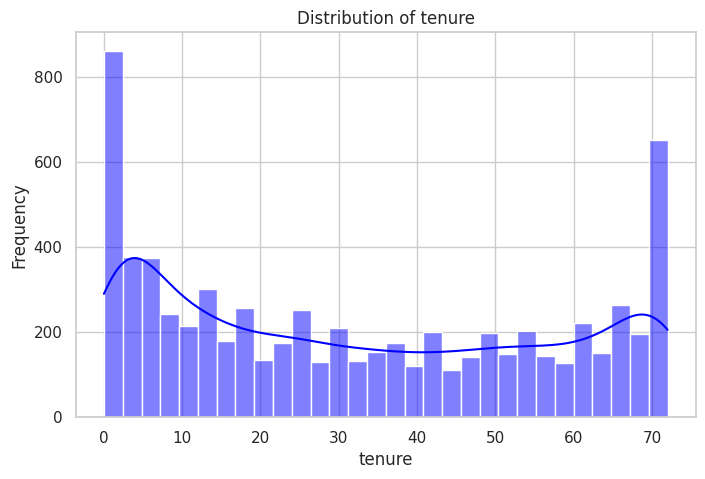

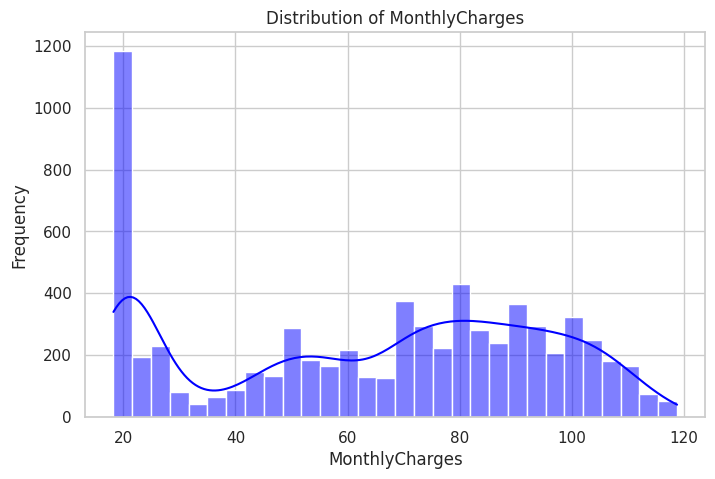

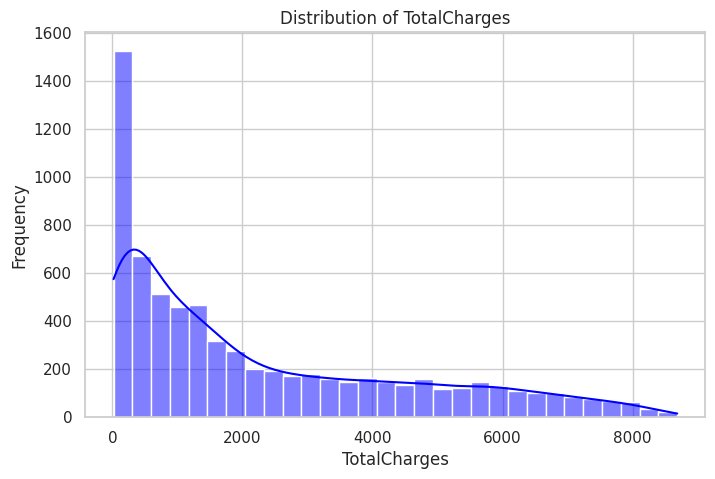

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


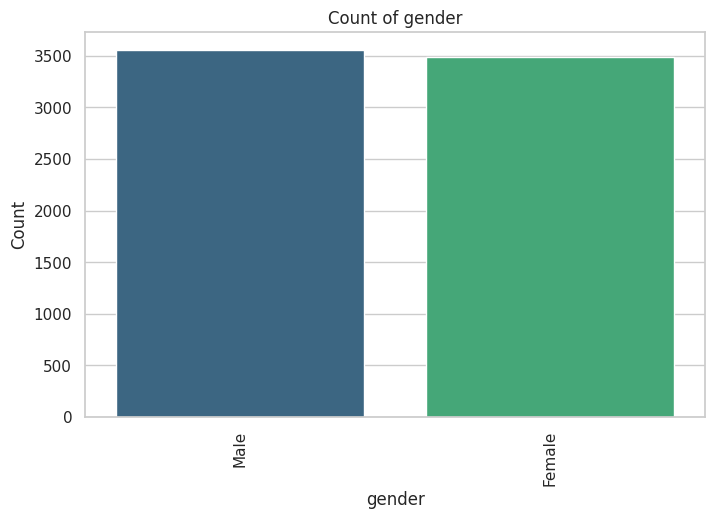

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


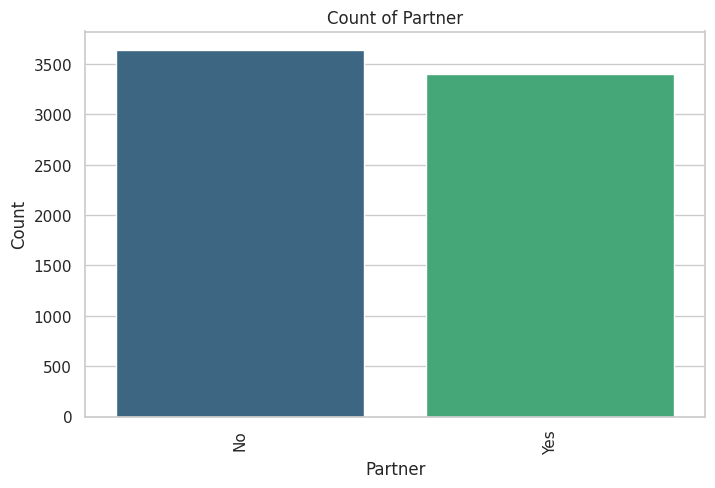

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


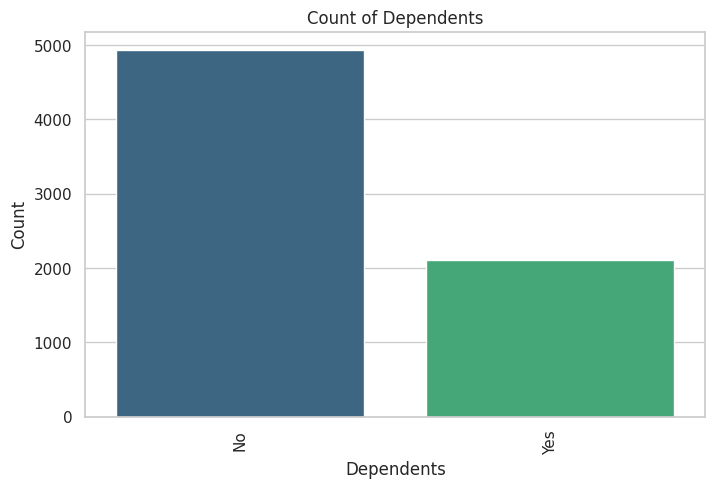

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


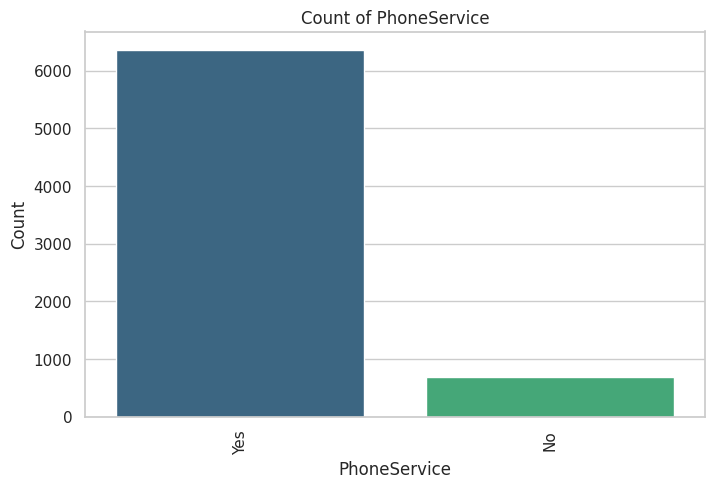

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


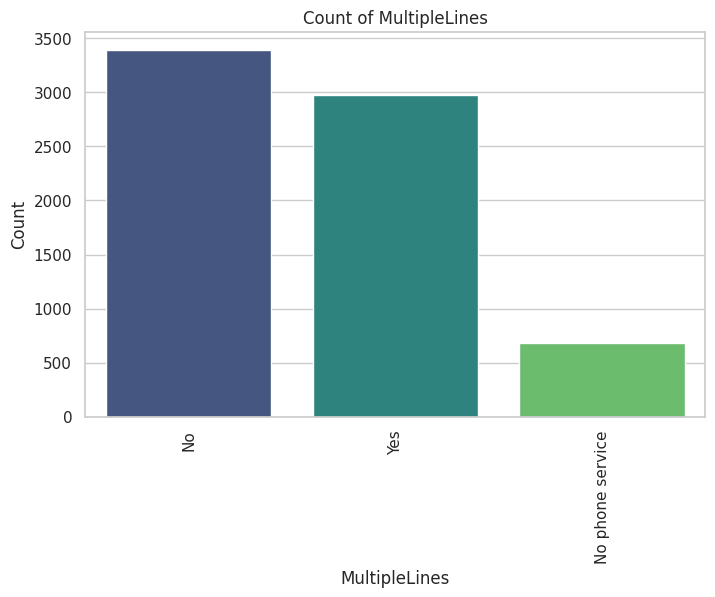

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


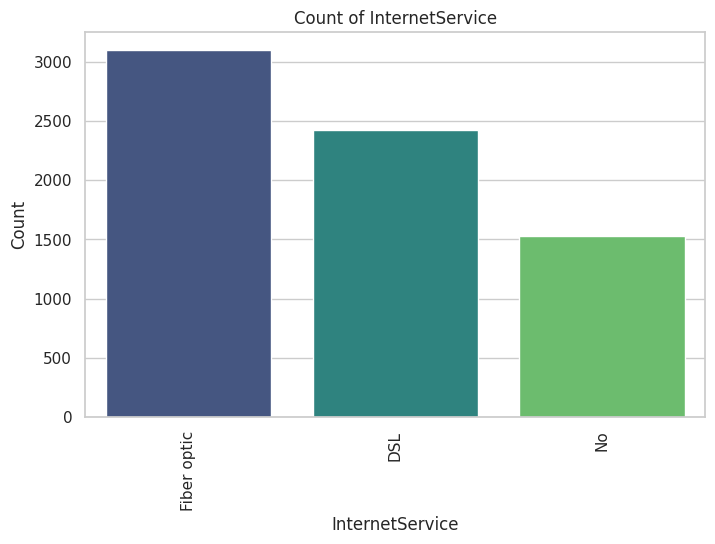

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


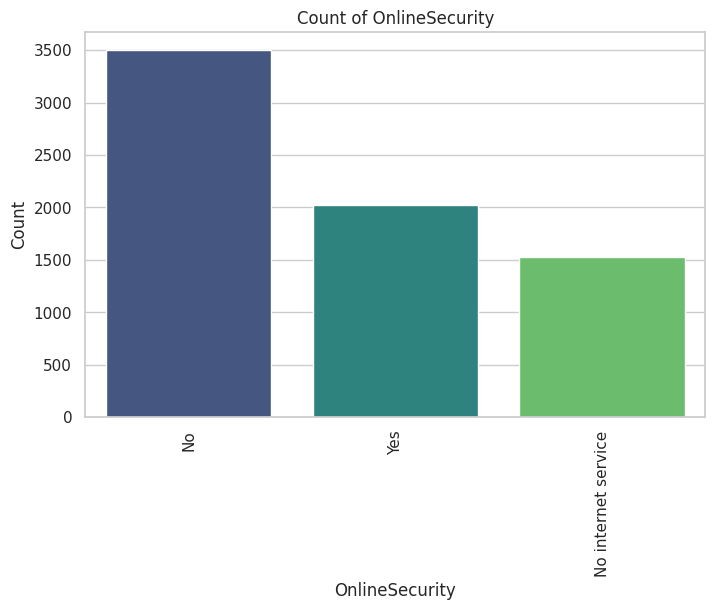

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


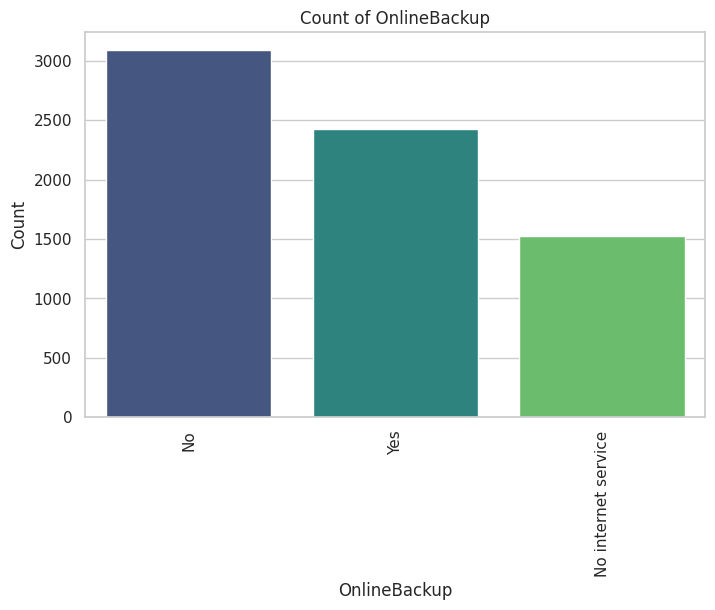

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


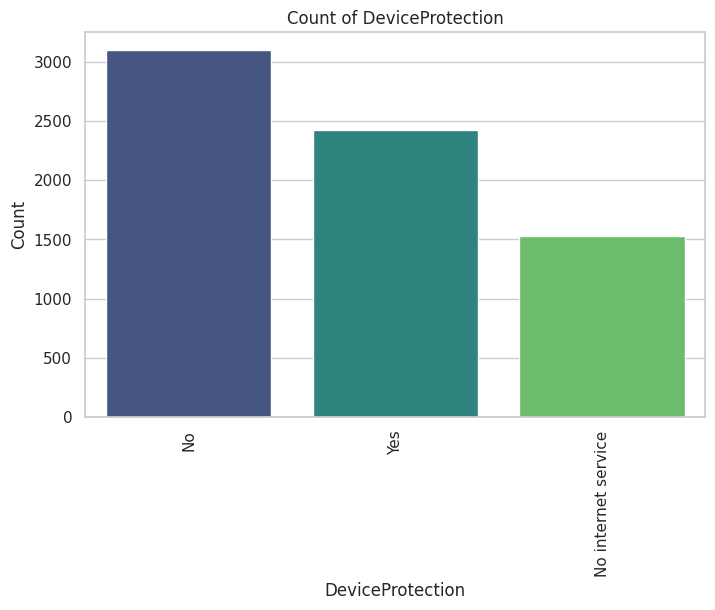

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


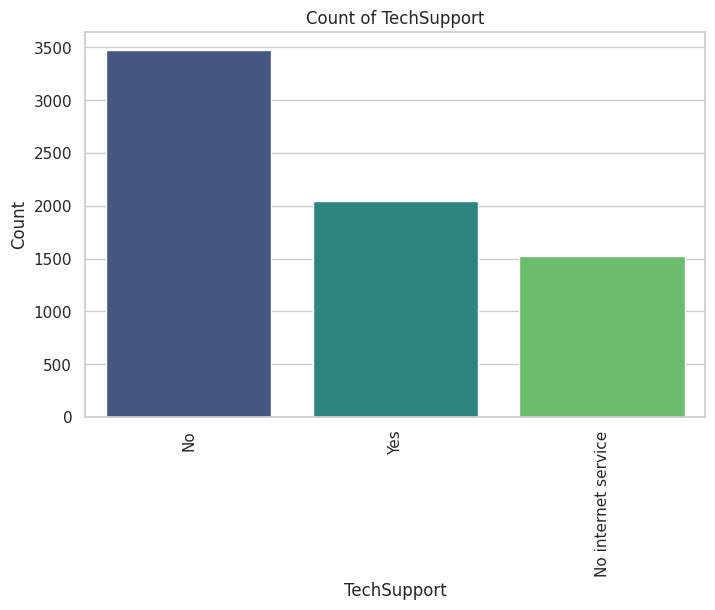

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


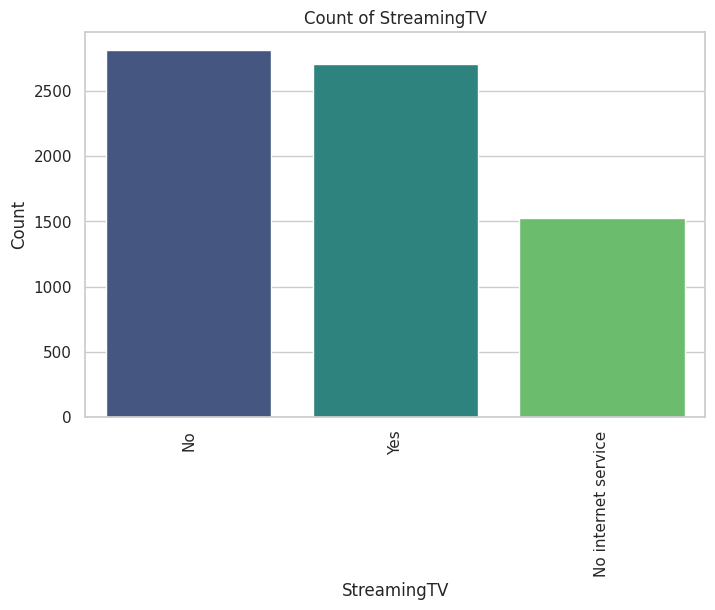

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


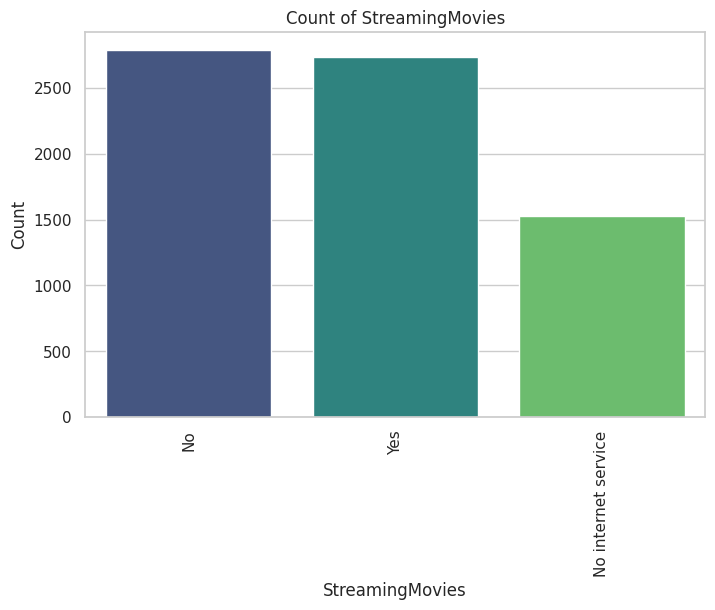

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


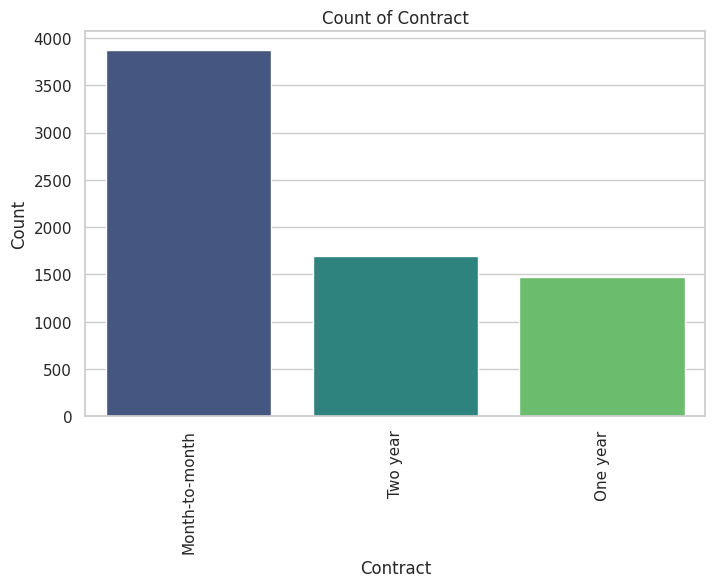

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


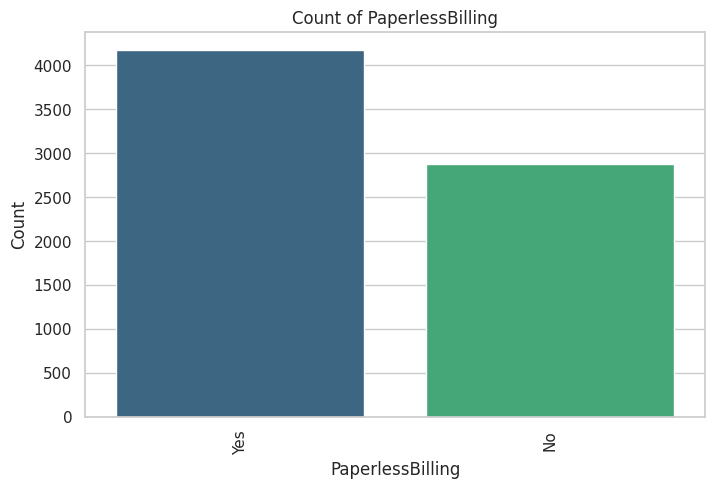

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


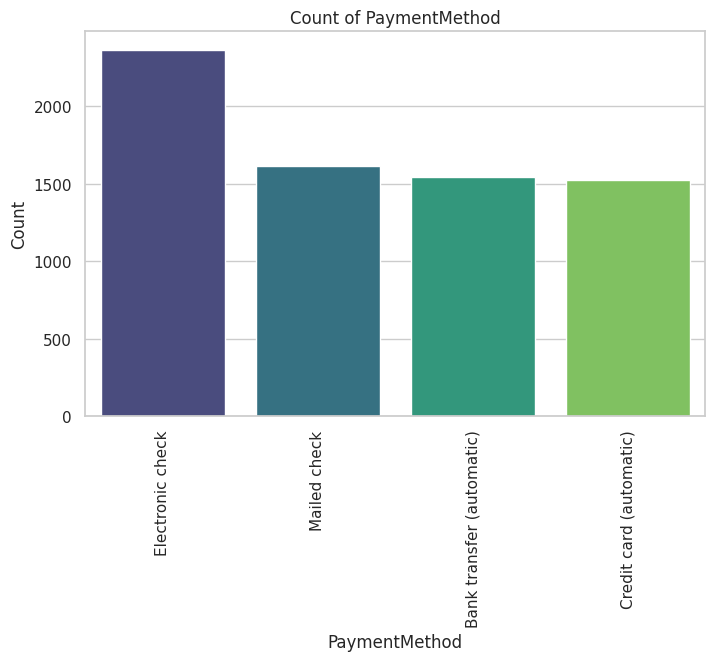

<ipython-input-4-d8bacf8bd499>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, palette='viridis', order=df[column].value_counts().index)


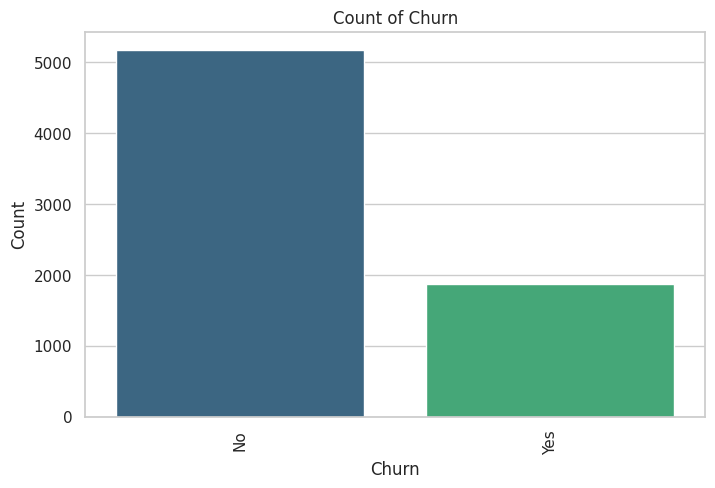

<ipython-input-5-18a56678891b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='tenure', palette='coolwarm')


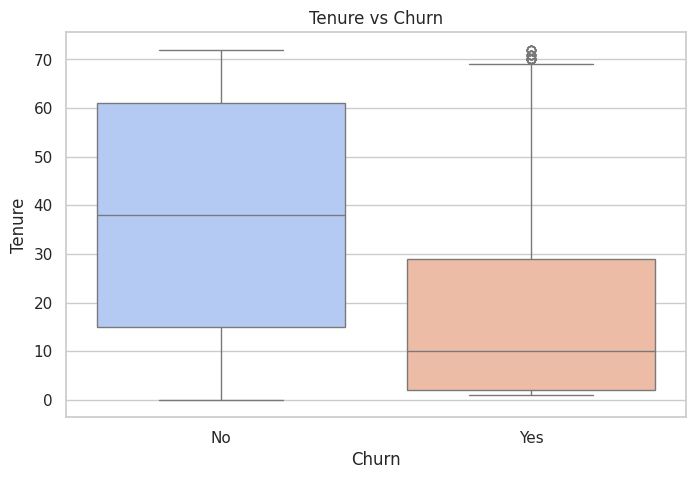

<ipython-input-5-18a56678891b>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette='coolwarm')


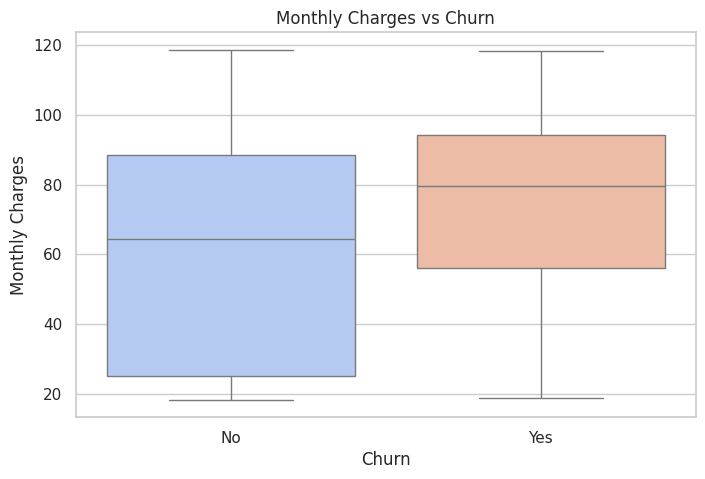

<ipython-input-5-18a56678891b>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='TotalCharges', palette='coolwarm')


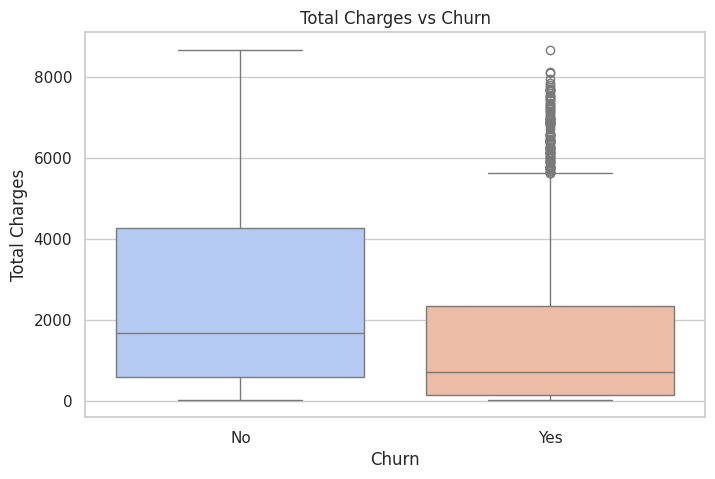

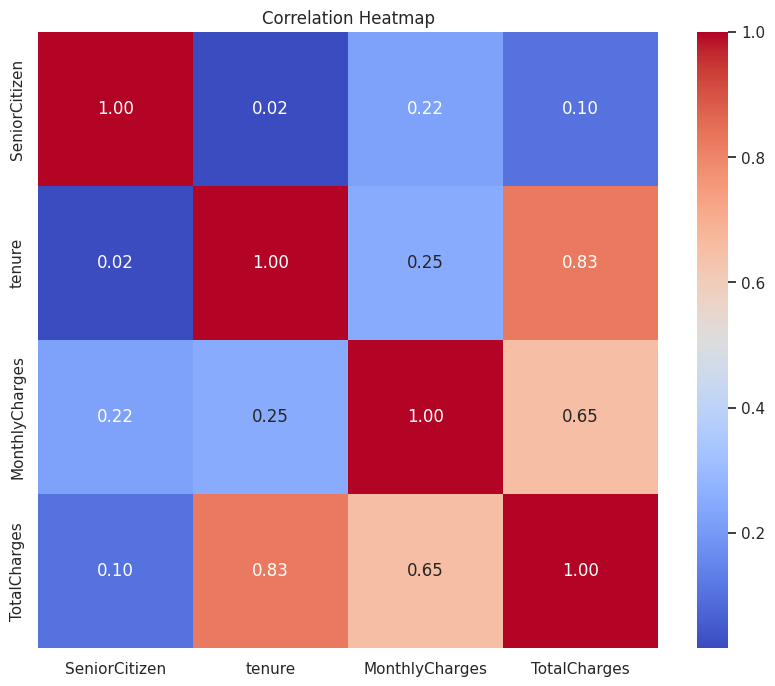

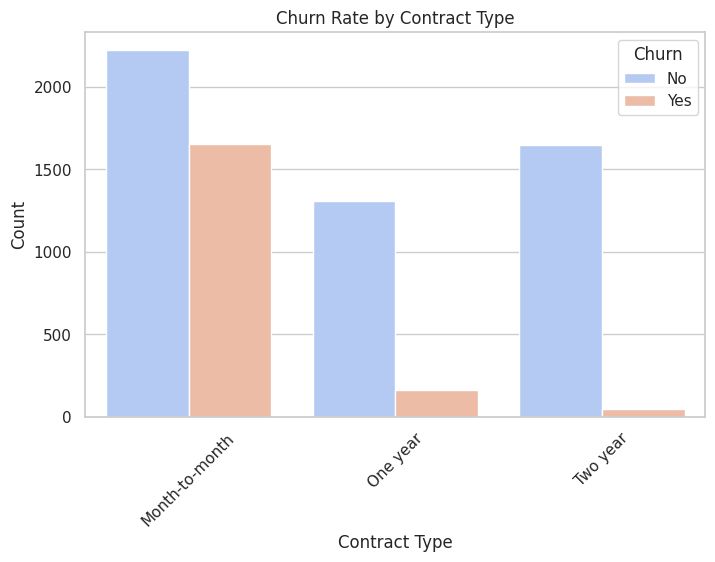

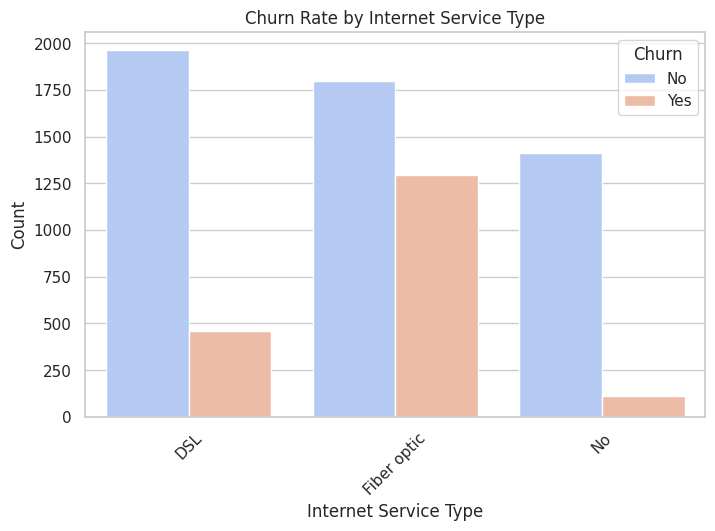

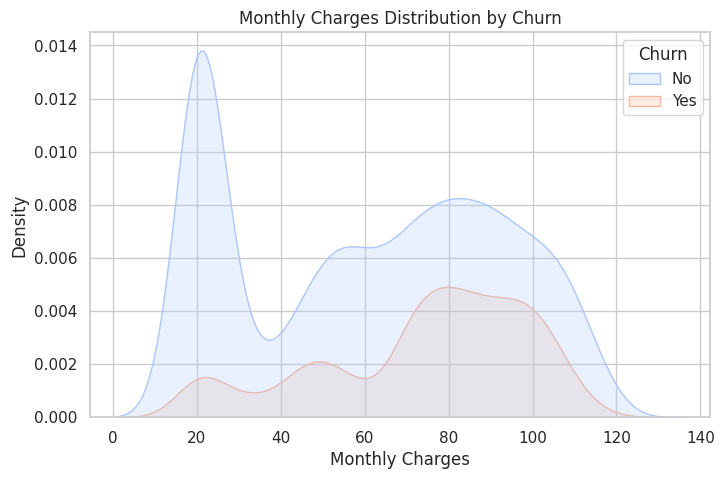


Statistical Testing for Feature Significance:
Chi-Square Test for gender: p-value = 0.4866
Chi-Square Test for Partner: p-value = 0.0000
Chi-Square Test for Dependents: p-value = 0.0000
Chi-Square Test for PhoneService: p-value = 0.3388
Chi-Square Test for MultipleLines: p-value = 0.0035
Chi-Square Test for InternetService: p-value = 0.0000
Chi-Square Test for OnlineSecurity: p-value = 0.0000
Chi-Square Test for OnlineBackup: p-value = 0.0000
Chi-Square Test for DeviceProtection: p-value = 0.0000
Chi-Square Test for TechSupport: p-value = 0.0000
Chi-Square Test for StreamingTV: p-value = 0.0000
Chi-Square Test for StreamingMovies: p-value = 0.0000
Chi-Square Test for Contract: p-value = 0.0000
Chi-Square Test for PaperlessBilling: p-value = 0.0000
Chi-Square Test for PaymentMethod: p-value = 0.0000
Chi-Square Test for Churn: p-value = 0.0000
ANOVA Test for tenure: p-value = nan
ANOVA Test for MonthlyCharges: p-value = nan
ANOVA Test for TotalCharges: p-value = nan
Training set shape: 

/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Performance:
Accuracy: 0.7927608232789212
Precision: 0.5939675174013921
Recall: 0.6863270777479893
F1 Score: 0.6368159203980099
Confusion Matrix:
[[861 175]
 [117 256]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86      1036
           1       0.59      0.69      0.64       373

    accuracy                           0.79      1409
   macro avg       0.74      0.76      0.75      1409
weighted avg       0.80      0.79      0.80      1409

Random Forest Performance:
Accuracy: 0.7856635911994322
Precision: 0.6005665722379604
Recall: 0.5683646112600537
F1 Score: 0.5840220385674931
Confusion Matrix:
[[895 141]
 [161 212]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1036
           1       0.60      0.57      0.58       373

    accuracy                           0.79      1409
   macro avg       0.72      0.72    

In [ ]:
# Step 8: Train and evaluate models
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000, random_state=42)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)

    print("Logistic Regression Performance:")
    evaluate_model(y_test, y_pred)

    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    print("Random Forest Performance:")
    evaluate_model(y_test, y_pred_rf)

    # Hyperparameter tuning for Random Forest
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=10, cv=3, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    best_score = random_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Cross-Validation Score:", best_score)

    # Retrain the Random Forest model with the best parameters
    optimized_rf_model = RandomForestClassifier(**best_params, random_state=42)
    optimized_rf_model.fit(X_train, y_train)
    y_pred_optimized_rf = optimized_rf_model.predict(X_test)

    print("Optimized Random Forest Performance:")
    evaluate_model(y_test, y_pred_optimized_rf)

# Helper function to evaluate models
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

# Main function to execute the steps
def main():
    data_path = 'Telco_data.csv'
    telco_df = load_data(data_path)
    telco_df = clean_data(telco_df)

    numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

    # Generate categorical columns dynamically
    categorical_columns = telco_df.select_dtypes(include='object').columns.tolist()
    categorical_columns.remove('customerID')  # Remove customerID if it's part of the data

    univariate_analysis(telco_df, numerical_columns, categorical_columns)
    bivariate_analysis(telco_df)

    # Add Churn Analysis step
    churn_analysis(telco_df)

    statistical_tests(telco_df, categorical_columns, numerical_columns)

    X_train, X_test, y_train, y_test = prepare_data(telco_df)
    train_and_evaluate_models(X_train, X_test, y_train, y_test)
if __name__ == "__main__":
    main()

**Step 8: Train and Evaluate Models**

**What Happens**

* Logistic Regression:

* A baseline logistic regression model is trained and evaluated.

**Random Forest**

* A random forest model is trained and evaluated.

**Hyperparameter Tuning**

* RandomizedSearchCV is used to find the best hyperparameters for the random forest model.

**Evaluation Metrics**

* Accuracy, precision, recall, F1 score, confusion matrix, and classification report are computed for each model.

**Analysis**

**Logistic Regression**

Provides a baseline performance metric. It is simple and interpretable but may not capture complex patterns.

**Random Forest**

* Typically performs better than logistic regression due to its ability to capture non-linear relationships.

**Hyperparameter Tuning**

* Improves the performance of the random forest model by optimizing parameters like n_estimators and max_depth.

**Evaluation Metrics**

* Precision and recall are particularly important for churn prediction, as false positives (predicting churn when the customer stays) and false negatives (missing churn) have different business implications.



**Step 9: Graph Findings Summary**

**Tenure vs Churn**

* Shorter tenure is strongly associated with higher churn. This suggests that retaining customers in the early months is crucial.

**MonthlyCharges vs Churn**

* Higher monthly charges correlate with higher churn, indicating pricing sensitivity.

**TotalCharges vs Churn**

* Lower total charges correlate with higher churn, suggesting that long-term customers are more loyal.

**Correlation Heatmap**

* Confirms that tenure and TotalCharges are highly correlated, which aligns with the intuition that longer tenure leads to higher total spending.

**Step 10: Model Performance Summary**

**Logistic Regression**

* Provides a baseline for comparison. It is fast and interpretable but may underperform on complex datasets.

**Random Forest**

* Outperforms logistic regression, especially after hyperparameter tuning. It captures complex relationships but is less interpretable.

**Optimized Random Forest**

* Achieves the best performance, with higher accuracy, precision, and recall.

**In summary:**

* The analysis reveals key drivers of churn, such as tenure, monthly charges, and contract type.

* The optimized random forest model is the best choice for predicting churn, as it balances performance and complexity.

* Business strategies should focus on retaining customers in the early months, offering competitive pricing, and encouraging long-term contracts.
